In [65]:
#!/usr/bin/env python
import os
import glob
import math
from typing import Iterator, DefaultDict, Dict
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import fasta_parser

In [3]:
def get_sequence_chunks(
        sequence: str,
        window: int,
        step: int,
        as_overlap: bool = False,
) -> Iterator[str]:
    """GC Content in a DNA/RNA sub-sequence length k. In
    overlap windows of length k, other wise non overlapping.

    Inputs:
        sequence - a string representing a DNA sequence.
        as_overlap - boolean that represents if overlap is needed.
        k - a integer representing the lengths of overlapping bases.
            Default is 20.

    Outputs:
        subseq - a string representing a slice of the sequence with or without
                 overlapping characters.
    """
    sequence = sequence.upper()

    if as_overlap:
        # overlap sequence length
        step = 1

    # iterates to the overlap region
    for i in range(0, len(sequence) - window + 1, step):
        # creates the substring
        subseq = sequence[i:i + window]
        start = i
        end = i + window
        yield subseq, start, end


In [32]:
len('TAGTTGTGAA')

10

In [31]:
s1 = "TAGTTGTGAAGAAAATATGGATAAACAGGACGACGAATGCTTTCACCGATAAGGACAACTTTCCATAACTCAGTAAATATAGTGCAGAGTTCACCCTGTC"
list(get_sequence_chunks(s1, 10, 10))

[('TAGTTGTGAA', 0, 10),
 ('GAAAATATGG', 10, 20),
 ('ATAAACAGGA', 20, 30),
 ('CGACGAATGC', 30, 40),
 ('TTTCACCGAT', 40, 50),
 ('AAGGACAACT', 50, 60),
 ('TTCCATAACT', 60, 70),
 ('CAGTAAATAT', 70, 80),
 ('AGTGCAGAGT', 80, 90),
 ('TCACCCTGTC', 90, 100)]

In [29]:
len(s1)

100

In [4]:
def gc_content(seq: str, percent: bool = True) -> float:
    """
    Calculate G+C content, return percentage (as float between 0 and 100).
    Copes mixed case sequences, and with the ambiguous nucleotide S (G or C)
    when counting the G and C content.  The percentage is calculated against
    the full length.

    Inputs:
        sequence - a string representing a sequence (DNA/RNA/Protein)

    Outputs:
        gc - a float number or a percent value representing the gc content of the sequence.

    """
    seq_len = len(seq)
    gc = sum(1 for x in seq if x.upper() in {"G", "C", "S"})
    if seq_len == 0:
        return 0
    gc /= seq_len
    if percent:
        return gc * 100
    return gc

In [5]:
def get_gc_content_slide_window(sequence: str, window: int, step: int) -> DefaultDict[str, float]:
    """
    Calculate the GC (G+C) content along a sequence. Returns a dictionary-like
    object mapping the sequence window to the gc value (floats).
    Returns 0 for windows without any G/C by handling zero division errors, and
    does NOT look at any ambiguous nucleotides.

    Inputs:
        sequence - a string representing a sequence (DNA/RNA/Protein)
        window_size - a integer representing the length of sequence to be analyzed
                   at each step in the full sequence.
        step - a integer representing the length of overlapping sequence allowed.

    Outputs:
        gc- a dictionary-like object mapping the window size sequence to it gc values
            as floating numbers
    """
    gc = defaultdict(float)
    for seq, start, end in get_sequence_chunks(sequence, window, step, as_overlap=False):
        key = f'{start}-{end}'
        gc[key] += gc_content(seq)
    return gc

In [6]:
def difference_gc(total_gc: float, gc_dict: Dict[str, float]) -> Dict[str, float]:
    """
    Calculates the difference between the mean GC content of window i, and the
    mean chromosomal GC content, as Di = GC i − GC
    """
    # iterate through all keys, gc calculated values for the
    # genome chunk
    # get the difference between the chromosomal mean and the chunks
    # add the difference to the appropriate chunk
    d_i = {
        chunk: gc_cnt - total_gc
        for chunk, gc_cnt in gc_dict.items()
    }
    return d_i

In [7]:
def get_chromosomal_gc_variation(difference_dic: Dict[str, float]) -> float:
    """
    Calculates the chromosomal GC variation defined as the log-transformed average
    of the absolute value of the difference between the mean GC content of each
    non-overlapping sliding window i and mean chromosomal GC content.
    chromosomal_gc_variantion = log(1/N*sum(|Di|), where N is the maximum number of
    non-overlapping window size in bp in a sliding windows.
    """
    # get the number of chunks
    n = len(difference_dic)
    arr = np.fromiter(
        difference_dic.values(),
        dtype=np.float32,
        count=len(difference_dic),
    )
    var = np.log(np.sum(np.abs(arr)) / n)
    return var

In [8]:
def plot_slide_window_data(data_dic, x_label, y_label, title, as_save=False):
    """
    Plot the data calculated in a slide window of a given sequence.
    
    Inputs:
        data_dic - a dictionary-like object representing the data calculated in a
                   sequence in a window size sample.
        x_label - a string representing the x labels to x axis of the plot.
        y_label - a string representing the y labels to y axis of the plot.
        title - a string representing the title of the plot.
        as_save - a boolean that is default to false and not save any figure.
    
    Outputs:
        a plot figures to be save is as_save or just show the plot.
    """
    plt.figure(num=None, figsize=(15, 7), dpi=100)
    plt.plot(data_dic.keys(), data_dic.values(), color='#1f77b4', linestyle='--', marker='.', alpha=0.5)
    plt.tight_layout()
    plt.xlabel(f'{x_label} (kbp)')
    plt.ylabel(f'{y_label}')
    plt.title(f'{title}')
    plt.xticks(rotation=90)
    plt.grid()
    if as_save:
        plt.savefig(f'{title}.png')
    else:
        plt.show()

In [21]:
def test() -> None:
    s = (
        "TAGTTGTGAAGAAAATATGGATAAACAGGACGACGAATGCTTTCACCGATAAGGACAACTTTCCATAACTCAGTAAATATAGTGCAGAGTTCACCCTGTC"
    )

    seq_gc_non_overlap = get_gc_content_slide_window(s, 20, 20)
    expected = {
        '0-20': 30,
        '20-40': 45,
        '40-60': 40,
        '60-80': 25,
        '80-100': 55,
    }
    assert expected.keys() == seq_gc_non_overlap.keys()
    for k, v in expected.items():
        assert math.isclose(seq_gc_non_overlap[k], v)

    seq_gc_total = gc_content(s, percent=True)
    assert math.isclose(seq_gc_total, 39)

    seq_dif_gctot_gc_slidewindow = difference_gc(seq_gc_total, seq_gc_non_overlap)
    expected = {
        '0-20': -9,
        '20-40': 6,
        '40-60': 1,
        '60-80': -14,
        '80-100': 16,
    }
    assert expected.keys() == seq_dif_gctot_gc_slidewindow.keys()
    for k, v in expected.items():
        assert math.isclose(seq_dif_gctot_gc_slidewindow[k], v)

    chromosome_gc_variation = get_chromosomal_gc_variation(seq_dif_gctot_gc_slidewindow)
    assert math.isclose(chromosome_gc_variation, 2.2192034840549946)

In [23]:
test()

In [27]:
fasta_files = glob.glob('Data/Genomes_splitted/*/Chromosomes/*_chr.fna.gz')

In [41]:
def get_gc_data_from_genomes(filenames):
    gc_di = defaultdict(dict)
    gcvar = defaultdict(dict)
    for filename in filenames:
        for Id, seq in fasta_parser.parse_fasta(filename):
            gc_chr = gc_content(seq)
            gc_100pb = get_gc_content_slide_window(seq, 100, 100)
            gc_diff = difference_gc(gc_chr, gc_100pb)
            gc_var = get_chromosomal_gc_variation(gc_diff)
            gc_di[Id] = gc_diff
            gcvar[Id] = gc_var
    return gc_di, gcvar    

In [ ]:
di, var = get_gc_data_from_genomes(fasta_files)

In [67]:
pd.DataFrame(di)['GCF_013341275.1_chr']

0-100            -5.70075
100-200          -1.70075
1000-1100         3.29925
10000-10100      -0.70075
100000-100100     3.29925
                   ...   
999500-999600     2.29925
999600-999700    -3.70075
999700-999800     3.29925
999800-999900     0.29925
999900-1000000   -3.70075
Name: GCF_013341275.1_chr, Length: 32307, dtype: float64

In [57]:
x = [x.split('-')[0] for x in pd.DataFrame(di)['GCF_013341275.1_chr'].index]

In [60]:
y = pd.DataFrame(di)['GCF_013341275.1_chr'].values

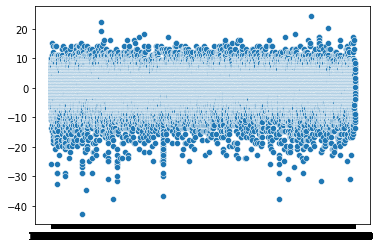

In [68]:
g =sns.scatterplot(x=x, y=y);

In [61]:
dict_gc_window = dict(zip(x, y))